# JuzData: proceso de generacion de causas - analisis temporal

En el presente notebook se analiza la columna 'exp_fechecho' de nuestro dataset, que contiene las fechas de los hechos que motivaron las causas judiciales. En consecuencia no vamos a meternos con el proceso de distribucion de causas, sino unicamente con su generacion; en particular, me interesa analizar si existe estacionalidad y autocorrelacion temporal en el proceso. 

Esta forma de mirar el problema es interesante para el desafío por dos razones: (1) en sí mismo, en la medida en que conocer el patrón temporal de generación de las hechos nos ayuda a entender mejor la estructura del fenómeno de conflictividad social que da lugar a las causas; y porque (2) entender el proceso desde su estructura temporal es clave para analizar la conveniencia de usar el tiempo como un factor de distribución y cómo afectaría eso la uniformidad entre juzgados.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('penal_df_fec.xlsx')

In [3]:
df['exp_fechecho_dt'] = pd.to_datetime(df['exp_fechecho'])
df[['exp_fechecho','exp_fechecho_dt']].head(10)

,exp_fechecho,exp_fechecho_dt
0,17/2/2014 00:00,2014-02-17
1,NaN,NaT
2,2014-03-12 00:00:00,2014-03-12
3,13/4/2015 00:00,2015-04-13
4,14/5/2015 00:00,2015-05-14
5,2015-01-08 00:00:00,2015-01-08
6,NaN,NaT
7,15/7/2015 00:00,2015-07-15
8,14/5/2015 00:00,2015-05-14
9,NaN,NaT


In [4]:
# convierto 'unknown' en NaN para contabilizar
import itertools as it
for i, col in it.product(df.index,df.columns):
    if df.at[i,col] == 'unknown':
        df.at[i,col] = np.nan

In [5]:
df['exp_fechecho_dt'].notna().sum()

13163

In [6]:
calendar = df['exp_fechecho_dt'].value_counts()
calendar.head()

2017-01-01    42
2016-12-02    32
2016-01-13    30
2016-04-14    30
2016-09-22    29
Name: exp_fechecho_dt, dtype: int64

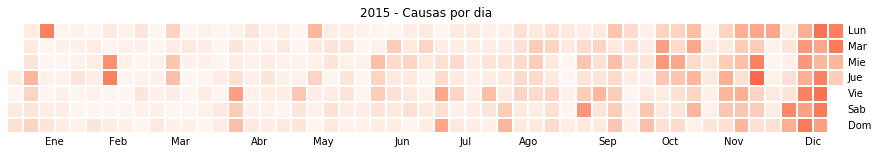

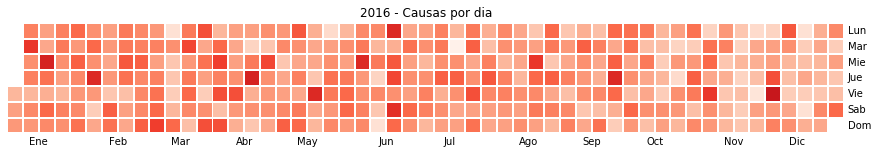

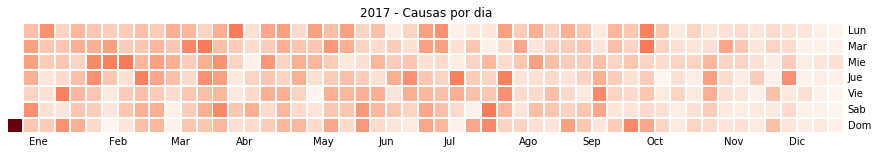

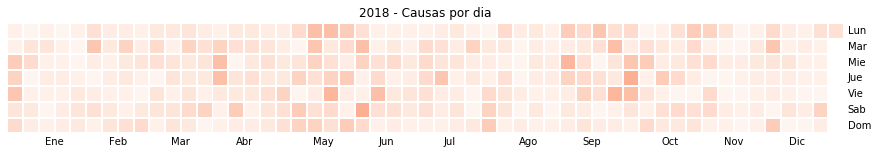

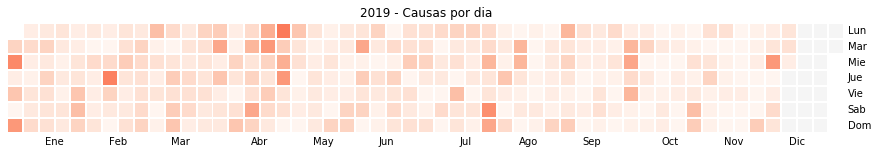

In [7]:
years = [2015,2016,2017,2018,2019]
dias = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']
meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul',
        'Ago','Sep','Oct','Nov','Dic']
for year in years:
    plt.figure(figsize=(15,10))
    calmap.yearplot(calendar, year=year,
                    daylabels=dias,
                   monthlabels=meses)
    plt.title(str(year) + ' - Causas por dia')
    file_name = 'calendar_heatmap_'+str(year)+'.png'
    plt.savefig(file_name)
    plt.show()

Que se puede ver en estos heatmaps: no parece haber una marcada estacionalidad (ver analisis mas abajo); el año 2016 presenta muchas mas causas que los demas (ver detalle abajo); y, lo que es mas importante a nuestros fines, se registra una tendencia a la autocorrelacion temporal de la cantidad de causas (lo que se aprecia visualmente en los clusters de más o menor intensidad de color). Esto significa que los hechos que dan lugar a causas se agrupan en clusters temporales (como ya vimos que lo hacen geográficamente).

In [40]:
# llevamos series a df
calendar_df = calendar.to_frame()
calendar_df = calendar_df.reset_index(drop=False)
calendar_df.head()

,index,exp_fechecho_dt
0,2017-01-01,42
1,2016-12-02,32
2,2016-01-13,30
3,2016-04-14,30
4,2016-09-22,29


In [41]:
year = pd.to_datetime('1/1/2015')
year

Timestamp('2015-01-01 00:00:00')

In [42]:
# renombramos
calendar_df = calendar_df.rename(columns={'index':'date','exp_fechecho_dt':'causas'})
# reordenamos por fecha, reseteamos el indice
calendar_df = calendar_df.sort_values(by='date').reset_index(drop=True)
# filtramos desde 2015
year_filter = pd.to_datetime('1/1/2015')
calendar_df = calendar_df[calendar_df['date'] >= year_filter]
calendar_df.head()

,date,causas
203,2015-01-01,2
204,2015-01-03,3
205,2015-01-04,5
206,2015-01-05,2
207,2015-01-06,3


A continuación vamos a desarrollar funciones para calcular los valores de autocorrelación con cuatro medidas: 
- Pearson (correlación paramétrica tradicional): cociente entre la covarianza y el producto de los desvíos de dos series de datos.
- rho de Spearman (correlación de rangos, no paramétrica): rankea las observaciones de las series y calcula la correlación de Pearson de dicho ranking.
- tau de Kendall (correlación de rangos, no paramétrica): también analiza la correlación ordinal, utilizando comparaciones entre pares de observaciones (estudiando si son concordantes o discordantes, i.e., si las dos series varían en la misma dirección o no).
- Autocorrelación parcial: regresión de una serie sobre sus valores laggeados, se utiliza en la metodología Box-Jenkins.

In [68]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.tsa.stattools import pacf

Para la función de autocorrelación parcial no tengo el p-value (para las demás sí); la librería de statsmodels me da los intervalos de confianza. Armamos una función para calcular el p-value (con una precisión determinada)

In [73]:
# Función para p-value desde PACF

In [74]:
def auto_corr(corr_function, series, 
              lags = 7, name='',
              alpha = 0.05):
    """
        Calcula autocorrelación y p-values correspondientes para la función de
        correlación especificada.
        
        corr_function - función de correlación: pearsonr, spearmanr, kendalltau
        series - serie de tiempo a analizar
        lags - cuantos períodos considerar
        name - nombre de la función para dataframe
        alpha - alpha para intervalo de PACF
    """
    auto_values = []
    
    if corr_function is pacf:
        print('Armar función para PACF')
        return
    else:
        p_values = []
        for i in range(1,lags+1):
            pearson = pearsonr(series[i:],series.shift(i)[i:])
            auto_values.append(pearson[0])
            p_values.append(pearson[1])
    
    results = {
        'lag': range(1,lags+1),
        str(name + '_corr'): auto_values,
        str(name + '_p-val'): p_values,
    }
    
    df = pd.DataFrame(results)
    
    return df

In [55]:
test = auto_corr(pearsonr, 
                 calendar_df['causas'], 
                 lags = 7, name = 'pearson')

In [56]:
test

,lag,pearson_corr,pearson_p-val
0,1,0.713865,0.0
1,2,0.719100,0.0
2,3,0.682517,0.0
3,4,0.676128,0.0
4,5,0.663669,0.0
5,6,0.663092,0.0
6,7,0.661362,0.0


In [75]:
# Falta PACF
def correlations_df(series, lags = 7): 
    pearson_full = auto_corr(pearsonr, 
                             series, 
                             lags = lags, name = 'pearsonr')

    spearman_full = auto_corr(spearmanr, 
                             series, 
                             lags = lags, name = 'spearmanr')

    kendall_full = auto_corr(kendalltau, 
                             series, 
                             lags = lags, name = 'kendalltau')

    correlations_full = pearson_full.merge(spearman_full, on = 'lag')
    correlations_full = correlations_full.merge(kendall_full, on = 'lag')
    return correlations_full

In [67]:
correlations_df(calendar_df['causas'],lags = 7)

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val
0,1,0.713865,0.0,0.713865,0.0,0.713865,0.0
1,2,0.719100,0.0,0.719100,0.0,0.719100,0.0
2,3,0.682517,0.0,0.682517,0.0,0.682517,0.0
3,4,0.676128,0.0,0.676128,0.0,0.676128,0.0
4,5,0.663669,0.0,0.663669,0.0,0.663669,0.0
5,6,0.663092,0.0,0.663092,0.0,0.663092,0.0
6,7,0.661362,0.0,0.661362,0.0,0.661362,0.0


In [76]:
# Plotear

Es decir, una autocorrelación grande, de signo positivo y significativa, para las tres medidas de correlación.

## Analisis por año

In [12]:
df.columns

Index(['org_idradactual', 'exp_cuij', 'org_idintpri', 'org_cod_pri',
       'org_descorta_pri', 'org_descr_Pri', 'org_idintseg', 'est_id',
       'est_descr', 'exp_anio', 'exp_cuerpos', 'exp_fojas', 'exp_detenidos',
       'exp_id', 'exp_sufijo', 'exp_fechecho', 'exp_fecinidem', 'exp_fecini',
       'exp_fecreg', 'exp_fecsor', 'exp_fecelev', 'exp_letra', 'oju_id',
       'oju_descr', 'exp_ultmov', 'exp_ultmovf', 'den_id', 'den_cod_casoMPF',
       'Tipo_ingreso_MPF', 'org_cod', 'org_descr', 'org_descorta', 'org_den',
       'org_descorta_Den', 'org_descr_Den', 'den_flagrante', 'Comuna',
       'den_barrio', 'den_calle_id', 'den_cod_postal', 'den_fec_hecho',
       'den_fec_ingreso_MPF', 'den_fec_ini_comi', 'den_hora_hecho',
       'den_latitud', 'den_longitud', 'den_tipo_den', 'den_loc_id',
       'den_sin_lugar_hecho', 'den_v_domestica', 'den_v_genero', 'den_zon_id',
       'den_zona', 'filter_.', 'org_destino_act', 'PrimarioDen_id',
       'PrimarioDen_id_oju', 'PrimarioExp_id', 'Pri

In [13]:
df_year_groupby = df.groupby(df['exp_fechecho_dt'].dt.year)
df_year_count = df_year_groupby.count()['exp_cuij'].to_frame(name='causas')
df_year_count

,causas
exp_fechecho_dt,
1969.0,32
2006.0,1
2007.0,1
2008.0,2
2009.0,2
2010.0,4
2011.0,1
2012.0,16
2013.0,66


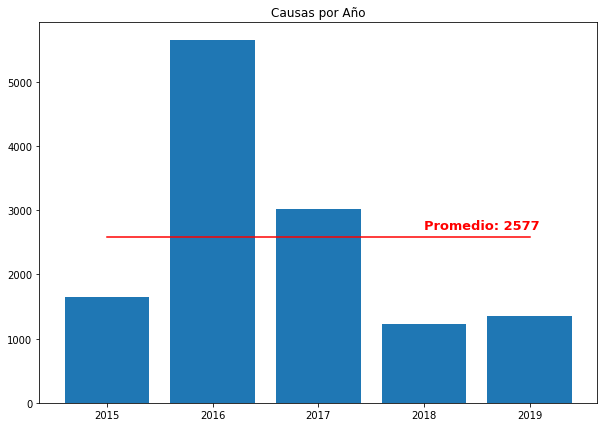

In [14]:
anios = ['2015','2016','2017','2018','2019']
plt.figure(figsize=(10,7))
plt.bar(x=anios,
        height=df_year_count.values.flatten()[-5:])
year_avg = np.mean(df_year_count.values.flatten()[-5:])
plt.plot([year_avg for i in range(5)],c='red')
plt.annotate('Promedio: '+str(int(year_avg)),
             (3,2700),c='red',fontsize=13,
            fontweight='bold')
plt.title('Causas por Año')
plt.savefig('causas_por_anio.png')
plt.show()

Estas diferencias entre la cantidad de causas por año muy probablemente se deba a complicaciones en la migración de datos entre bases (como hablamos en la última reunión con Yasmin Quiroga).

In [15]:
df_year_count.index = df_year_count.index.astype(int)
df_year_count.index = df_year_count.index.astype(str)

In [16]:
calendar_level = pd.DataFrame()
for i,index in enumerate(calendar.index):
    calendar_level.at[i,'fecha'] = index
    calendar_level.at[i,'causas'] = calendar[index]
    # llevamos el año al type de df_year_count
    year = str(index.year)
    causas_year = df_year_count.at[year,'causas']
    calendar_level.at[i,'causas-level'] = calendar[index] / causas_year

In [17]:
calendar_level.head()

,fecha,causas,causas-level
0,2017-01-01,42.0,0.013935
1,2016-12-02,32.0,0.005670
2,2016-01-13,30.0,0.005315
3,2016-04-14,30.0,0.005315
4,2016-09-22,29.0,0.005138


In [18]:
calendar_level['fecha'] = pd.to_datetime(calendar_level['fecha'])

In [19]:
calendar_level_series = pd.Series(data=calendar_level['causas-level'].values,
                                  index=calendar_level['fecha'])

In [20]:
calendar_level_series.head()

fecha
2017-01-01    0.013935
2016-12-02    0.005670
2016-01-13    0.005315
2016-04-14    0.005315
2016-09-22    0.005138
dtype: float64

## Autocorrelación por Año

In [21]:
def print_autocorr(year):
    df = calendar_df[calendar_df['date'].dt.year == year]
    print(f'Año: {year}')
    print()
    calendar_pearson = pearsonr(df['causas'],df['causas-lag'])
    print(f'Autocorrelación Pearson: {calendar_pearson[0]}')
    print('p-value Pearson: {:.20f}'.format(calendar_pearson[1]))
    print()
    calendar_spearman = spearmanr(df['causas'],df['causas-lag'])
    print(f'Autocorrelación Spearman: {calendar_spearman[0]}')
    print('p-value Spearman: {:.20f}'.format(calendar_spearman[1]))
    print()
    calendar_kendall = kendalltau(df['causas'],df['causas-lag'])
    print(f'Autocorrelación Kendall: {calendar_kendall[0]}')
    print('p-value Kendall: {:.20f}'.format(calendar_kendall[1]))
    print()

In [23]:
for year in [2015,2016,2017,2018,2019]:
    print_autocorr(year)

Año: 2015

Autocorrelación Pearson: 0.5635521385484641
p-value Pearson: 0.00000000000000000000

Autocorrelación Spearman: 0.5387646370378005
p-value Spearman: 0.00000000000000000000

Autocorrelación Kendall: 0.4201137660079833
p-value Kendall: 0.00000000000000000000

Año: 2016

Autocorrelación Pearson: 0.08233417974683208
p-value Pearson: 0.10812854934371898818

Autocorrelación Spearman: 0.1289239937225562
p-value Spearman: 0.01166657927339972284

Autocorrelación Kendall: 0.09040777834717546
p-value Kendall: 0.01214011078908504813

Año: 2017

Autocorrelación Pearson: 0.325223529340529
p-value Pearson: 0.00000000000000575570

Autocorrelación Spearman: 0.26587779398769285
p-value Spearman: 0.00000000025487231061

Autocorrelación Kendall: 0.204734363674238
p-value Kendall: 0.00000000040566572009

Año: 2018

Autocorrelación Pearson: -0.06267409587008893
p-value Pearson: 0.06812203605061163680

Autocorrelación Spearman: -0.052860144227395094
p-value Spearman: 0.12402037799965434650

Autocor

## Autocorrelación: Dickey-Fuller, Ploteo

In [ ]:
import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh', title='Title'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(title+'\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
for year in [2015,2016,2017,2018,2019]:
    series = calendar_df[calendar_df['date'].dt.year == year]['causas']
    tsplot(series, lags=10, title='Time Series Año '+str(year))

## Estacionalidad: causas por meses

In [ ]:
df_month_groupby = df.groupby(df['exp_fechecho_dt'].dt.month)
df_month_count = df_month_groupby.count()['exp_cuij'].to_frame(name='causas')
df_month_count

In [ ]:
month_avg = np.mean(df_month_count.values)
month_avg

In [ ]:
meses = ['Ene','Feb','Mar','Abr','May','Jun',
         'Jul','Ago','Sep','Oct','Nov','Dic']
plt.figure(figsize=(15,6))
plt.bar(x=meses,
        height=df_month_count.values.flatten())
plt.plot([month_avg for i in range(12)],c='red')
plt.annotate('Promedio: '+str(int(month_avg)),
             (9,1120),c='red',fontsize=13,
            fontweight='bold')
plt.title('Causas por Mes')
plt.savefig('causas_por_mes.png')
plt.show()

No parece haber fuerte estacionalidad en los meses (faltaría un test formal).

## Estacionalidad: causas por dias

In [ ]:
df_weekday_groupby = df.groupby(df['exp_fechecho_dt'].dt.weekday)
df_weekday_count = df_weekday_groupby.count()['exp_cuij'].to_frame(name='causas')
df_weekday_count

In [ ]:
weekday_avg = np.mean(df_weekday_count.values)
weekday_avg

In [ ]:
dias = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']
plt.figure(figsize=(15,6))
plt.bar(x=dias,
        height=df_weekday_count.values.flatten())
plt.plot([weekday_avg for i in range(7)],c='red')
plt.annotate('Promedio: '+str(int(weekday_avg)),
             (5,1900),c='red',fontsize=13,
            fontweight='bold')
plt.title('Causas por Mes')
plt.savefig('causas_por_mes.png')
plt.show()

No parece haber fuerte estacionalidad en los días de la semana.

## Discusión Conceptual

- Autocorrelación temporal: modelos empíricos, componente teórico débil (inercia). No aplicaría en nuestro caso. El origen puede estar en la captación de datos? (lo hablamos en la última call, lo sugiere Martina en la minuta).
- Autocorrelación espacial: muy utilizada en criminología. Problema econométrico de selection bias. Teoría relacionada: broken window (no confundir con Rudolph Giuliani).
- Autocorrelación temporal en criminología: efecto contagio (cómo operaría?)

## Expedientes

In [ ]:
# separo exp_cuij en tres columnas
for i in df.index:
    df.at[i,'exp_cuij_1'] = df.at[i,'exp_cuij'][0:2]
    df.at[i,'exp_cuij_2'] = df.at[i,'exp_cuij'][3:11]
    df.at[i,'exp_cuij_3'] = df.at[i,'exp_cuij'][12:13]

In [ ]:
df.shape

In [ ]:
# expedientes unicos segun exp_cuij
df['exp_cuij_2'].unique().shape

In [ ]:
# expedientes unicos segun exp_id
df['exp_id'].unique().shape